In [1]:
import time
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [9]:
dtypes = {'카드번호':str, '트랜잭션ID':str, '환승횟수':int, '카드구분코드':str,
          '총이용객수':int, '교통카드사용자구분':int, '교통수단코드1':int, '교통수단코드2':int,
          '교통수단코드3':int, '교통수단코드4':int, '교통수단코드5':int,
          '노선ID1':str, '노선ID2':str, '노선ID3':str, '노선ID4':str, '노선ID5':str,
          '차량ID1':str, '차량ID2':str, '차량ID3':str, '차량ID4':str, '차량ID5':str,
          '통행거리1':int, '통행거리2':int, '통행거리3':int, '통행거리4':int, '통행거리5':int,
          '총통행거리':int,
          '탑승시간1':int, '탑승시간2':int, '탑승시간3':int, '탑승시간4':int, '탑승시간5':int,
          '총탑승시간':int, '총소요시간':int,
          '승차일시1':str, '승차일시2':str, '승차일시3':str, '승차일시4':str, '승차일시5':str,
          '하차일시1':str, '하차일시2':str, '하차일시3':str, '하차일시4':str, '하차일시5':str,
          '최종승차일시':str, '최종하차일시':str,
          '승차역ID1':str, '승차역ID2':str, '승차역ID3':str, '승차역ID4':str, '승차역ID5':str,
          '하차역ID1':str, '하차역ID2':str, '하차역ID3':str, '하차역ID4':str, '하차역ID5':str,
          '최종승차역ID':str, '최종하차역ID':str, '총통행건수':int, '총요금':int}
trip_chain = pd.read_csv('SC_20170522.csv', encoding='cp949', dtype=dtypes)


## method = 교통수단, line = 노선

In [2]:
excel_file = pd.ExcelFile('1705코드정보.xlsx')
method = pd.read_excel(excel_file, sheet_name='교통수단', 
                       dtype={'교통수단코드':int, '교통수단명':str}, skiprows=[1]).set_index('교통수단코드').to_dict()['교통수단명']
line = pd.read_excel(excel_file, sheet_name='버스노선', names=['노선코드', '노선명'], 
                     dtype={'노선코드':str, '노선명':str}, skiprows=[0]).set_index('노선코드').to_dict()['노선명']
print(line['41110016'])

750번(B,유성,은평차고지~서울대)


In [3]:
excel_file = pd.ExcelFile('버스노선정류장정보.xlsx')
route_station_df = excel_file.parse(usecols=['노선ID', '정류장ID', '시도구분'], converters={'정류장ID':lambda ID: ("%07d"%ID)}).drop_duplicates()
seoul_route_station_df = route_station_df.loc[route_station_df.시도구분=='서울특별시']
seoul_route_station_df.head()

,노선ID,정류장ID,시도구분
0,11110034,8501970,서울특별시
1,11110034,8001321,서울특별시
2,11110034,0071130,서울특별시
3,11110034,0070881,서울특별시
4,11110034,0070882,서울특별시


In [4]:
excel_file = pd.ExcelFile('정류장기반정보_20171.xlsx')
subway_df = pd.read_excel(excel_file, sheet_name='최종', usecols=[1, 3, 4, 5, 6, 8, 9], 
                            names=['ID', '정류장명', '대존', '중존', '소존', '경도', '위도'], 
                            dtype={'정류장명': str, '대존':str, '중존':str, '소존':str, '경도': np.float64, '위도': np.float64}, 
                            skiprows=[0], nrows=664,
                            converters={'ID':lambda ID: ("%04d"%ID)})
bus_df = pd.read_excel(excel_file, sheet_name='최종', usecols=[1,3, 8, 9], 
                            names=['ID', '정류장명', '경도', '위도'], 
                            dtype={'정류장명': str, '경도': np.float64, '위도': np.float64}, 
                            skiprows=list(range(665)),
                            converters={'ID':lambda ID: ("%07d"%ID)})
# 특정 ID의 이름을 알 수 있음
station_name = dict(subway_df.set_index('ID').to_dict()['정류장명'],
                 **bus_df.set_index('ID').to_dict()['정류장명'])
# 특정 ID의 경도를 알 수 있음
longitude = dict(subway_df.set_index('ID').to_dict()['경도'],
                 **bus_df.set_index('ID').to_dict()['경도'])
# 특정 ID의 위도를 알 수 있음
latitude = dict(subway_df.set_index('ID').to_dict()['위도'],
                **bus_df.set_index('ID').to_dict()['위도'])


In [20]:
def isPeakTime(s):
    try:
        hour = int(s[8:10])
        return (hour >= 9) and (hour < 10)
    except:
        return False
def getHour(s):
    try:
        return int(s[8:10])
    except:
        return 999999
    
def getTime(s):
    try:
        return int(s[8:14])
    except:
        return 999999
def getName(ID):
    try:
        return station_name[ID]
    except:
        return np.nan

def getLong(ID):
    try:
        return longitude[ID]
    except:
        return np.nan

def getLat(ID):
    try:
        return latitude[ID]
    except:
        return np.nan
    
def getRouteNum(totalLine, ID):
    try:
        return int(totalLine.loc[totalLine['최종하차역ID'] == ID].lines)
    except:
        return 0

def getLoadFactor(totalLine, ID, population):
    try : 
        return float(population / getRouteNum(totalLine,ID))
    except:
        return 0
    
def getTotalLine(transfer):
        #각 Condition은 환승 횟수임
        condition_trans1 = (transfer.하차역ID2 == '0')
        condition_trans2 = ~condition_trans1 & (transfer.하차역ID3 == '0')
        condition_trans3 = ~condition_trans1 & ~condition_trans2 & (transfer.하차역ID4 == '0')
        condition_trans4 = ~condition_trans1 & ~condition_trans2 & ~condition_trans3 & (transfer.하차역ID5 == '0')
        condition_trans5 = ~condition_trans1 & ~condition_trans2 & ~condition_trans3 & ~condition_trans4
        
        # 각 df는 [최종 버스노선 ID, 최종 하차역 ID] 두 개의 컬럼으로 구성된 데이터프레임
        df1 = transfer.loc[condition_trans1, ['노선ID1','하차역ID1']]
        df2 = transfer.loc[condition_trans2, ['노선ID2','하차역ID2']]
        df3 = transfer.loc[condition_trans3, ['노선ID3','하차역ID3']]
        df4 = transfer.loc[condition_trans4, ['노선ID4','하차역ID4']]
        df5 = transfer.loc[condition_trans4, ['노선ID5','하차역ID5']]

        # 컬럼명 통일
        df1.columns = ['노선ID','하차역ID']
        df2.columns = ['노선ID','하차역ID']
        df3.columns = ['노선ID','하차역ID']
        df4.columns = ['노선ID','하차역ID']
        df5.columns = ['노선ID','하차역ID']

        # df_all : 지하철 -> 버스 환승한 모든 사람들의 [최종버스노선ID,최종하차역ID]로 구성된 데이터프레임 
        # df_unique : 노선 ID, 하차역 ID 동일한 데이터 제거
        df_all = pd.concat([df1,df2,df3,df4,df5])
        df_unique = df_all.drop_duplicates(['노선ID','하차역ID'])
        # df_unique_lines_series : 각 하차역ID별로 지나는 노선수를 나타내는 Series
        df_unique_lines_series = df_unique.하차역ID.value_counts()

        # df_unique_lines : 위에서 구한 series를 final_df(최종하차역별 하차 인원수를 나타낸 데이터프레임)와 merge하기 위해 DataFrame으로 변환
        df_dict = {'최종하차역ID' : df_unique_lines_series.index, 'lines' : df_unique_lines_series.values}
        totalLine = pd.DataFrame(df_dict)
        return totalLine
        # e.g.) 서울여상 : bus_df[bus_df.ID =="9003721"]




def getFinalPosition(df):
    final_position = pd.DataFrame({'최종하차역ID': df.최종하차역ID, 
                                    '최종하차역명': df.최종하차역ID.map(getName),
                                    '경도': df.최종하차역ID.map(getLong), 
                                    '위도':df.최종하차역ID.map(getLat)})
    final_position = final_position.dropna(axis=0)

    final_position['X'] = final_position['경도'] - longitude[dst_ID]
    final_position['Y'] = final_position['위도'] - latitude[dst_ID]
    final_position['노선수'] = final_position['최종하차역ID'].map(lambda x : getRouteNum(totalLine, x))

    return final_position


def getFinalRegional(final_position, xlim=[-0.02, 0.02], ylim=[-0.02, 0.02]):
    # 필요한 Column을 추출하기
    condition_XY1 = (
        (xlim[0] < final_position['X']) & (final_position['X'] < xlim[1]) & 
        (ylim[0] < final_position['Y']) & (final_position['Y'] < ylim[1])
    )
    final_position_regional = final_position[condition_XY1]
    return final_position_regional


def getFinalPopulation(final_position):
    # 각 하차역 별 인원수
    final_stations_population_series = final_position[['최종하차역ID']].value_counts()
    final_stations_population_df = pd.DataFrame(final_stations_population_series,columns = ['population'])
    final_position_pop = pd.merge(final_position,final_stations_population_df, on = '최종하차역ID')
    return final_position_pop

In [7]:
class StationTripChain:
    #### initialization ####
    def __init__(self, name, dataframe=None):
        self.name = name
        self.IDs = subway_df[subway_df.정류장명 == self.name].ID.to_list()
        if dataframe is None:
            self.df = pd.DataFrame(columns=trip_chain.columns)
            self.preprocessing()
        else:
            if not isinstance(dataframe, pd.DataFrame):
                raise TypeError("dataframe argument should be pandas DataFrame")
            self.df = dataframe

        condition = (self.df.최종하차역ID.apply(lambda ID: ID in self.IDs))
        
        # 현재 역이 최종하차역인 사람들
        self.finalstop_df = self.df.loc[condition].copy()
        # 현재 역이 환승역인 사람들
        self.transfer_df = self.df.loc[~condition].copy()

            

    ##### 전처리 작업 : 2호선 서울대입구역에서 내린 trip의 데이터를 분리 ####
    def preprocessing(self):
        '''
        아래 과정을 거치고 나면 self.df는 서울대에 내렸던 사람들로만 구성되며,
        각 행의 1번 하차역이 서울대입구역이 되며, 환승시간 기반으로 자름.
        만약에 2번 하차역, 4번 하차역이 서울대입구역이라면 이 사람은 2개의 행으로
        나뉘어져서 self.df에 추가되고 각각의 행의 1번 하차역은 서울대입구역임.
        이때 가정이 하나 필요한데, 환승시간 기반으로 하나의 trip에서 서울대입구역에
        2번 이상 도착하는 사람은 없을 것임.
        '''
        condition = (
            (trip_chain.하차역ID1.apply(lambda ID: ID in self.IDs)) |
            (trip_chain.하차역ID2.apply(lambda ID: ID in self.IDs)) |
            (trip_chain.하차역ID3.apply(lambda ID: ID in self.IDs)) |
            (trip_chain.하차역ID4.apply(lambda ID: ID in self.IDs)) |
            (trip_chain.하차역ID5.apply(lambda ID: ID in self.IDs))
        )
        self.df = trip_chain[condition].copy()

        
    ##### Get specific time dataframe ####
    def setPeriod(self, start_time = 7, end_time = 8):
        is_period_of = lambda x: self.__is_period_of(x, start_time, end_time)
        condition = (
            (self.df.하차역ID1.apply(lambda ID: ID in self.IDs)) & (self.df.하차일시1.map(is_period_of)) |
            (self.df.하차역ID2.apply(lambda ID: ID in self.IDs)) & (self.df.하차일시2.map(is_period_of)) |
            (self.df.하차역ID3.apply(lambda ID: ID in self.IDs)) & (self.df.하차일시3.map(is_period_of)) |
            (self.df.하차역ID4.apply(lambda ID: ID in self.IDs)) & (self.df.하차일시4.map(is_period_of)) |
            (self.df.하차역ID5.apply(lambda ID: ID in self.IDs)) & (self.df.하차일시5.map(is_period_of))
        )
        self.period_df = self.df[condition].copy()
                        
        condition = (self.period_df.최종하차역ID.apply(lambda ID: ID in self.IDs))
        
        # 현재 역이 최종하차역인 사람들
        self.period_finalstop_df = self.period_df.loc[condition].copy()
        # 현재 역이 환승역인 사람들
        self.period_transfer_df = self.period_df.loc[~condition].copy()
        
    def kmeans(self):
        pass
    
    #### internal function ####
    def __is_period_of(self, s, start_time, end_time):
        try:
            hour = self.__getHour(s)
            return (hour >= start_time) and (hour < end_time)
        except:
            return False
        
    def __getHour(self, s):
        try:
            return int(s[8:10])
        except:
            return 999999
        
    def __getTime(self, s):
        try:
            return int(s[8:14])
        except:
            return 999999

In [ ]:
condition = (subway_df.대존 == '서울특별시')
line = subway_df[condition].정류장명.unique()

for name in tqdm(line):
    print(name + " 시작")
    stc = StationTripChain(name)
    stc.df.to_csv('환승시간분리/'+name+'.csv', sep= ',' ,na_rep = 'NAN', encoding='utf-8-sig')

  0%|          | 0/285 [00:00<?, ?it/s]

서울역 시작
시청역 시작
종각역 시작
종로3가역 시작
종로5가역 시작
동대문역 시작
신설동역 시작
제기동역 시작
청량리역 시작
동묘앞역 시작
을지로입구역 시작
을지로3가역 시작
을지로4가역 시작
동대문역사문화공원역 시작
신당역 시작
상왕십리역 시작
왕십리역 시작
한양대역 시작
뚝섬역 시작
성수역 시작
건대입구역 시작
구의역 시작
강변역 시작
잠실나루역 시작
잠실역 시작
신천역 시작
종합운동장역 시작
삼성역 시작
선릉역 시작
역삼역 시작
강남역 시작
교대역 시작
서초역 시작
방배역 시작
사당역 시작
낙성대역 시작
서울대입구역 시작
봉천역 시작
신림역 시작
신대방역 시작
구로디지털단지역 시작
대림역 시작
신도림역 시작
문래역 시작
영등포구청역 시작
당산역 시작
합정역 시작
홍대입구역 시작
신촌역 시작
이대역 시작
아현역 시작
충정로역 시작
용답역 시작
신답역 시작
도림천역 시작
양천구청역 시작
신정네거리역 시작
용두역 시작
구파발역 시작
연신내역 시작
불광역 시작
녹번역 시작
홍제역 시작
무악재역 시작
독립문역 시작
경복궁역 시작
안국역 시작
충무로역 시작
동대입구역 시작
약수역 시작
금호역 시작
옥수역 시작
압구정역 시작
신사역 시작
잠원역 시작
고속터미널역 시작
남부터미널역 시작
양재역 시작
매봉역 시작
도곡역 시작
대치역 시작
학여울역 시작
대청역 시작
일원역 시작
수서역 시작
가락시장역 시작
경찰병원역 시작
오금역 시작
당고개역 시작
상계역 시작
노원역 시작
창동역 시작
쌍문역 시작
수유역 시작
미아역 시작
미아사거리역 시작
길음역 시작
성신여대입구역 시작
한성대입구역 시작
혜화역 시작
명동역 시작
회현역 시작
숙대입구역 시작
삼각지역 시작
신용산역 시작
이촌역 시작
동작역 시작
총신대입구역 시작
남태령역 시작
남영역 시작
용산역 시작
노량진역 시작
대방역 시작
영등포역 시작
서빙고역 시작
한남역 시작
응봉역 시작
회기역 시작
외대앞역 시작
신이문역 시작
석계역 시작
광운대역 시작
월계역 시작
녹천역 시작
한티역 시작
구룡역 시작
개포동역 시작
대모산입구역

서울대입구역 1/1


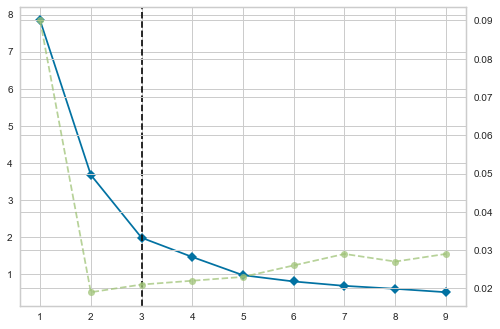

In [10]:
total_load = pd.DataFrame({'지하철역명': ['NAN'], 'cluster' : ['NAN'], 'load' : ['NAN'], '시간대' : ['NAN']}) 
total_load
# condition = (subway_df.ID < '0300') & (subway_df.ID >= '0200')
condition = (subway_df.대존 == '서울특별시')
line = subway_df[condition].정류장명.unique()
line = ['서울대입구역']
# 여기에 각 역별로 최대 쏠림이 발생한 시간대와 그 시간대의 최대부하량, 최대부하군집을 기록할 것임
history_df = pd.DataFrame(columns=['역명', '최대쏠림시간', '최대부하량', '최대부하군집'])
times = np.arange(6, 24, 1)
times = [7]

for idx, name in enumerate(line):
    dst_name = name
    dst_IDs = subway_df[subway_df.정류장명 == name].ID.to_list()
    dst_ID = dst_IDs[0]
    print(dst_name, "{}/{}".format(idx+1, len(line)))
    
    try:
        stc = StationTripChain(dst_name, dataframe=pd.read_csv('환승시간분리/'+name+'.csv', dtype=dtypes))
    except:
        print("기존 파일이 없어서 새로 계산을 시작합니다.")
        stc = StationTripChain(dst_name)
        
        
    max_load_time_df = None
    max_load_time_dict = {
        '역명': name,
        '최대쏠림시간': 0,
        '최대부하량': 0,
        '최대부하군집': 0,
    }
    for t in times:
        stc.setPeriod(t, t+1)

        total = stc.df
        total_peak = stc.period_df
        final = stc.period_finalstop_df
        transfer = stc.period_transfer_df


        #각 Condition은 환승 횟수임
        condition_trans1 = (total.하차역ID2 == '0')
        condition_trans2 = ~condition_trans1 & (total.하차역ID3 == '0')
        condition_trans3 = ~condition_trans1 & ~condition_trans2 & (total.하차역ID4 == '0')
        condition_trans4 = ~condition_trans1 & ~condition_trans2 & ~condition_trans3 & (total.하차역ID5 == '0')
        condition_trans5 = ~condition_trans1 & ~condition_trans2 & ~condition_trans3 & ~condition_trans4
        
        # 각 df는 [최종 버스노선 ID, 최종 하차역 ID] 두 개의 컬럼으로 구성된 데이터프레임
        df1 = total.loc[condition_trans1, ['노선ID1','하차역ID1']]
        df2 = total.loc[condition_trans2, ['노선ID2','하차역ID2']]
        df3 = total.loc[condition_trans3, ['노선ID3','하차역ID3']]
        df4 = total.loc[condition_trans4, ['노선ID4','하차역ID4']]
        df5 = total.loc[condition_trans4, ['노선ID5','하차역ID5']]

        # 컬럼명 통일
        df1.columns = ['노선ID','하차역ID']
        df2.columns = ['노선ID','하차역ID']
        df3.columns = ['노선ID','하차역ID']
        df4.columns = ['노선ID','하차역ID']
        df5.columns = ['노선ID','하차역ID']

        # df_all : 지하철 -> 버스 환승한 모든 사람들의 [최종버스노선ID,최종하차역ID]로 구성된 데이터프레임 
        # df_unique : 노선 ID, 하차역 ID 동일한 데이터 제거
        df_all = pd.concat([df1,df2,df3,df4,df5])
        df_all_bus = df_all[df_all.하차역ID.apply(lambda ID: ID not in dst_ID)]
        df_unique = df_all_bus.drop_duplicates(['노선ID','하차역ID'])
        # df_unique_lines_series : 각 하차역ID별로 지나는 노선수를 나타내는 Series
        df_unique_lines_series = df_unique.하차역ID.value_counts()

        # df_unique_lines : 위에서 구한 series를 final_df(최종하차역별 하차 인원수를 나타낸 데이터프레임)와 merge하기 위해 DataFrame으로 변환
        df_dict = {'최종하차역ID' : df_unique_lines_series.index, 'lines' : df_unique_lines_series.values}
        df_unique_lines = pd.DataFrame(df_dict)
        totalLine = df_unique_lines
        # e.g.) 서울여상 : bus_df[bus_df.ID =="9003721"]

        # 현재는 서울대입구역에서 다른 걸로 환승한 사람들의 경위도 데이터만 나오게 만들었음
        # 서울대입구역에 하차한 모든 사람들의 위치를 알고싶으면 transfer 대신 total 쓰면 됨

        final_position = pd.DataFrame({'최종하차역ID': transfer.최종하차역ID, 
                                       '최종하차역명': transfer.최종하차역ID.map(getName),
                                       '경도': transfer.최종하차역ID.map(getLong), 
                                       '위도':transfer.최종하차역ID.map(getLat)})
        final_position = final_position.dropna(axis=0)

        final_position['X'] = final_position['경도'] - longitude[dst_ID]
        final_position['Y'] = final_position['위도'] - latitude[dst_ID]
        final_position['노선수'] = final_position['최종하차역ID'].map(lambda x : getRouteNum(totalLine, x))

        final_position

        
        ##################################################################################
        ########################### K-means Clustering ###################################
        ##################################################################################
        # 필요한 Column을 추출하기
        condition_XY1 = (final_position['X'] < 0.02) & (final_position['X'] > -0.02) & (final_position['Y'] < 0.03) & (final_position['Y'] > -0.03)
        final_position_regional = final_position[condition_XY1]

        # 각 하차역 별 인원수
        final_stations_population_series = final_position_regional[['최종하차역ID']].value_counts()
        final_stations_population_df = pd.DataFrame(final_stations_population_series,columns = ['population'])
        final_position_regional_pop = pd.merge(final_position_regional,final_stations_population_df, on = '최종하차역ID')
        final_position_regional_pop

        try:
            # 중복제거된 각 역별 population Dataframe
            final_df_lowpop = final_position_regional_pop.drop_duplicates(['최종하차역ID'],keep="first").copy()
            final_df_lowpop['부하량'] = final_df_lowpop.apply(lambda x: getLoadFactor(totalLine,x['최종하차역ID'], x['population']), axis=1)


            final_df = final_df_lowpop

            data = final_df[['X', 'Y']]
            final_df.sort_values(by='부하량', ascending=False)


            # 정규화 진행, 여기서는 각 column의 최소값을 0, 최대값을 1에 매핑한 MinMaxScalar이용
            scaler = MinMaxScaler()
            data_scale = scaler.fit_transform(data)

            # K elbow : K means에서 최적의 K 찾아주는
            model1 = KMeans()
            visualizer = KElbowVisualizer(model1, k=(1,10))


            visualizer.fit(data_scale)
            # visualizer.show()

            # data_scale은 위에서 정규화한 데이터 사용


            ## Learning

            # elbow k
            k = visualizer.elbow_value_

            # 그룹 수, random_state 설정(초기 그룹 설정마다 최종 결과가 달라져서 실행마다 결과를 같게만듦)
            model = KMeans(n_clusters = k, random_state = 10)

            # 정규화된 데이터에 학습
            model.fit(data_scale)

            # 방법 1 : 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
            final_df['cluster'] = model.fit_predict(data_scale)


            total_pop = final_df.population.sum()

            ratio = {}

            for i in range(k):
                ratio[i] = (final_df.loc[final_df.cluster == i].population.sum()/total_pop)

            final_df['비중부하량'] = final_df.apply((lambda x : ratio[x.cluster] * x.부하량), axis=1)
            final_df.to_csv('./final_position/'+ dst_name + '_' + str(t) + '시' + '.csv', sep=',', encoding='utf-8-sig')

            sum_of_cluster = final_df.groupby(['cluster'])['비중부하량'].sum()
            maxload = sum_of_cluster.max()
            maxcluster = sum_of_cluster.idxmax()
            if max_load_time_dict['최대부하량'] < maxload:
                max_load_time_dict['최대쏠림시간'] = t
                max_load_time_dict['최대부하량'] = maxload
                max_load_time_dict['최대부하군집'] = maxcluster
                max_load_time_df = final_df
                        

            # df_pop_lines = pd.merge(final_df,df_unique_lines)
            df_pop_lines = final_df
            # df_pop_lines["load"] = df_pop_lines.population.map(float) / df_pop_lines.lines.map(float)
            df_pop_lines["load"] = df_pop_lines.부하량.map(float)

            #df_pop_lines.to_csv("df_pop_lines.csv", sep = ',' , na_rep = 'NAN' )
            a = []
            for i in range(1,k+1):
                a.append(df_pop_lines.loc[df_pop_lines.cluster == i].load.sum())

            cluster_load = pd.DataFrame({'지하철역명':[dst_name]*k, 'cluster' : [i for i in range(1,k+1)], 'load' : a, '시간대' : ['오전']*k}) 
            pd.concat([total_load, cluster_load]) 

            # e.g.) 서울여상 df_pop_lines[df_pop_lines.최종하차역ID == "9003721"]
        except:
            print("no cluster because of not enough data")
    if max_load_time_df is not None:
        history_df.loc[history_df.shape[0]] = max_load_time_dict
        maxtime = max_load_time_dict['최대쏠림시간']
    

history_df.to_csv('./final_position/history.csv', sep=',', encoding='utf-8-sig')

서울대입구역 1/2
낙성대역 2/2


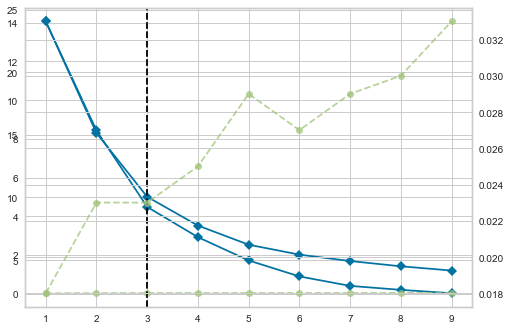

In [33]:
condition = (subway_df.대존 == '서울특별시')
line = subway_df[condition].정류장명.unique()
line = ['서울대입구역', '낙성대역']
# 여기에 각 역별로 최대 쏠림이 발생한 시간대와 그 시간대의 최대부하량, 최대부하군집을 기록할 것임
times = np.arange(6, 24, 1)
times = [7,8,18,19]
rank_df = pd.DataFrame(columns=['역명', '최대쏠림시간', '최대부하량', '최대부하군집'])

for idx, name in enumerate(line):
    dst_name = name
    dst_IDs = subway_df[subway_df.정류장명 == name].ID.to_list()
    dst_ID = dst_IDs[0]
    print(dst_name, "{}/{}".format(idx+1, len(line)))
    
    try:
        stc = StationTripChain(dst_name, dataframe=pd.read_csv('환승시간분리/'+name+'.csv', dtype=dtypes))
    except:
        print("기존 파일이 없어서 새로 계산을 시작합니다.")
        stc = StationTripChain(dst_name)
        
    total = stc.df
    final = stc.finalstop_df
    transfer = stc.transfer_df

    totalLine = getTotalLine(transfer)
    final_position = getFinalPosition(transfer)
    final_position_regional = getFinalRegional(final_position, xlim=(-0.02, 0.02), ylim=(-0.03, 0.03))
    final_df = final_position_regional.drop_duplicates(['최종하차역ID'],keep="first").copy()
    data = final_df[['X', 'Y']]
    try:
        scaler = MinMaxScaler()
        data_scale = scaler.fit_transform(data)
        visualizer = KElbowVisualizer(model1, k=(1,10))
        visualizer.fit(data_scale)
        k = visualizer.elbow_value_
        model = KMeans(n_clusters = k, random_state = 10)
        model.fit(data_scale)
        final_df['cluster'] = model.fit_predict(data_scale)
        final_df.to_csv('./final_position/'+ dst_name + '_cluster.csv', sep=',', encoding='utf-8-sig', index=False)
        cluster_dict = final_df.set_index('최종하차역ID').to_dict()['cluster']
    except:
        print("no cluster because of not enough data")
        continue

    history_df = pd.DataFrame(columns=(['시간']+list(range(k))))
    max_load_time_dict = {
        '역명': name,
        '최대쏠림시간': 0,
        '최대부하량': 0,
        '최대부하군집': 0,
    }

    for t in times:
        # t is time
        stc.setPeriod(t, t+1)
        transfer = stc.period_transfer_df
        final_position = getFinalPosition(transfer)
        final_position_regional = getFinalRegional(final_position, xlim=(-0.02, 0.02), ylim=(-0.03, 0.03))
        final_position_regional_pop = getFinalPopulation(final_position_regional)
        final_df = final_position_regional_pop.drop_duplicates(['최종하차역ID'],keep="first").copy()
        final_df['부하량'] = final_df.apply(lambda x: getLoadFactor(totalLine, x['최종하차역ID'], x['population']), axis=1)
        final_df['cluster'] = final_df['최종하차역ID'].apply(lambda ID: cluster_dict[ID])
        data = final_df[['X', 'Y']]
        total_pop = final_df.population.sum()
        ratio = {}
        for i in range(k):
            ratio[i] = (final_df.loc[final_df.cluster == i].population.sum()/total_pop)
        final_df['비중부하량'] = final_df.apply((lambda x : ratio[x.cluster] * x.부하량), axis=1)
        final_df.to_csv('./final_position/'+ dst_name + '_' + str(t) + '시' + '.csv', sep=',', encoding='utf-8-sig', index=False)
        sum_of_cluster = final_df.groupby(['cluster'])['비중부하량'].sum()
        history_df.loc[history_df.shape[0]] = [t] + sum_of_cluster.to_list()
        maxload = sum_of_cluster.max()
        maxcluster = sum_of_cluster.idxmax()
        if max_load_time_dict['최대부하량'] < maxload:
            max_load_time_dict['최대쏠림시간'] = t
            max_load_time_dict['최대부하량'] = maxload
            max_load_time_dict['최대부하군집'] = maxcluster
    
    history_df.to_csv('./final_position/'+ dst_name + '_history.csv', sep=',', encoding='utf-8-sig', index=False)
    rank_df.loc[rank_df.shape[0]] = max_load_time_dict

rank_df.to_csv('./final_position/rank.csv', sep=',', encoding='utf-8-sig', index=False)

In [ ]:
## 시각화
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

# 인원수에 비례한 Scatter
for i in range(k):    
    plt.scatter(df_pop_lines.loc[df_pop_lines['cluster'] == i  ,  'X'], df_pop_lines.loc[df_pop_lines['cluster'] == i, 'Y'], 
                s = list(map(lambda x: 10*x, list(df_pop_lines.loc[df_pop_lines['cluster'] == i, 'load']))), label= 'cluster ' + str(i))


# 서울대 vs. 서울대 입구역
plt.scatter(0,0,marker = '.', s = 500, c = 'y')
plt.text(-0.005,-0.003693,"Seoul Nat'l Univ. Station", fontsize = 15)
plt.text(-0.005,-0.025,"Seoul Nat'l Univ.", fontsize = 15)
# plt.scatter(x, y for x, y in cluster_centers_)
# x = 경도, y = 위도, label = cluster 1,2,3

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('longtitude', size = 12)
plt.ylabel('latitude', size = 12)
# for i in range(3):
#     plt.scatter(*(model.cluster_centers_[i]))
plt.savefig(dst_name+".png")
plt.show()

print(model.cluster_centers_)



In [ ]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('silver')
plt.scatter(final_position.X, final_position.Y, s=5)
# 서울대입구역
# plt.scatter(longitude[dst_ID], longitude[dst_ID], marker='*', c='r', s=100)
plt.scatter(0, 0, marker='*', c='r', s=100)
# 공대입구
# plt.scatter(longitude['0014384'], latitude['0014384'], marker='*', c='y', s=100)
plt.scatter(longitude['0014384']-longitude[dst_ID], latitude['0014384']-latitude[dst_ID], marker='*', c='y', s=100)
# plt.xlim(126.7, 127.2)
# plt.ylim(37.2, 37.7)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()

In [ ]:
# 버스환승인구 중 서울대 안으로 들어오는 사람 3573명
final_position.query('경도 < 126.961824 and 경도 > 126.945998 and 위도 > 37.446188 and 위도 < 37.470730')

In [ ]:
## 최종 하차역마다 노선수 구하기

# 흐름 : 전체 데이터에서 하차역을 기준으로 중복되는 값을 구하는 Dataframe 가져오기.
# -> 그리고 다시 각 하차역을 Key로 하여 새 column으로 추가해주기.

In [ ]:
total_load = pd.DataFrame({'지하철역명': ['NAN'], 'cluster' : ['NAN'], 'load' : ['NAN']}) 
total_load
subways = subway_df.정류장명
for subway in subways:
    make_dst_df(subway)
    preprocess_finalID()
    calculate_lines()
    make_final_position()
    calculate_loads()
    K_means()
    final_calculate()

In [ ]:
total_load

In [ ]:
# 아래 셀 추가된 사항
dstname(지하철 역)에서 출발한 버스가 도달한 정류장에다가 
해당 지하철 역을 지나온 버스 노선수를 나타낸 DataFrame
즉, dstname(지하철 역)마다 다르게 정의됨.

# 수정사항 1(22.05.09)
condition_trans을 기존에는 다음 이동이 없는 경우를 최종하차역으로 판단했지만, 되돌아오는 데이터도 기록되어 있으므로 승차역ID의 번호를 기준으로 환승 횟수를 파악하고, 그를 통해 하차역의 ID와 노선 ID를 연결짓는다. 최종하차역ID와 노선ID를 사용하지 않는이유는 몇번째 노선 ID가 최종하차인지를 확신할 수 없기때문이다.ex) 서울대입구에서 녹두로 1차환승하고 재환승한 경우는 최종하차역ID는 완전 다른곳에 있을 것이므로 배제해줘야함.

# 수정사항 2(22.05.09)
기존에는 분석 시간대에 맞춰 Dynamic하게 노선수를 계산했지만, 그냥 total 24시간을 기준으로 운용하는 노선으로 노선수를 계산하기로 바꿈.

In [ ]:
trip_chain = pd.read_csv('SC_20170522.csv', encoding='cp949', dtype={'카드번호':str, '트랜잭션ID':str, '환승횟수':int, '카드구분코드':str,
                                                                  '총이용객수':int, '교통카드사용자구분':int, '교통수단코드1':int, '교통수단코드2':int,
                                                                  '교통수단코드3':int, '교통수단코드4':int, '교통수단코드5':int,
                                                                  '노선ID1':str, '노선ID2':str, '노선ID3':str, '노선ID4':str, '노선ID5':str,
                                                                  '차량ID1':str, '차량ID2':str, '차량ID3':str, '차량ID4':str, '차량ID5':str,
                                                                  '통행거리1':int, '통행거리2':int, '통행거리3':int, '통행거리4':int, '통행거리5':int,
                                                                  '총통행거리':int,
                                                                  '탑승시간1':int, '탑승시간2':int, '탑승시간3':int, '탑승시간4':int, '탑승시간5':int,
                                                                  '총탑승시간':int, '총소요시간':int,
                                                                  '승차일시1':str, '승차일시2':str, '승차일시3':str, '승차일시4':str, '승차일시5':str,
                                                                  '하차일시1':str, '하차일시2':str, '하차일시3':str, '하차일시4':str, '하차일시5':str,
                                                                  '최종승차일시':str, '최종하차일시':str,
                                                                  '승차역ID1':str, '승차역ID2':str, '승차역ID3':str, '승차역ID4':str, '승차역ID5':str,
                                                                  '하차역ID1':str, '하차역ID2':str, '하차역ID3':str, '하차역ID4':str, '하차역ID5':str,
                                                                  '최종승차역ID':str, '최종하차역ID':str, '총통행건수':int, '총요금':int})
